In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import glob
from urllib.request import urlopen, Request 
from path import Path, getcwdu
import os
from pathlib import PurePath

import re

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, recall_score

In [2]:
train_file_list = [PurePath(file).name for file in glob.iglob('data/nc_training_filings/*')]
train_path_list = [PurePath(os.getcwd()).joinpath(file).as_posix() for file in glob.iglob('data/nc_training_filings/*')]
train_accession_ids = [PurePath(file).stem for file in train_file_list]
train_cik_nbrs = [x.split(sep='-')[0] for x in train_accession_ids]

### Exploring the train.csv

In [3]:
srp_df = pd.read_csv('data/share_repurchase_paragraphs.csv').sort_values('accession_number').reset_index()

In [4]:
srp_df['para_len'] = srp_df['paragraph_text'].apply(lambda x: len(x))

In [152]:
srp_df.columns

Index(['index', 'ticker', 'accession_number', 'data_key_friendly_name', 'text',
       'data_value', 'reported_data_value', 'reported_units', 'paragraph_text',
       'para_len'],
      dtype='object')

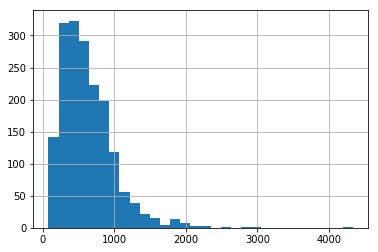

In [141]:
srp_df.para_len.hist(bins=30)
plt.show()

In [17]:
srp_df.data_key_friendly_name.value_counts()

Share Repurchase Authorization Date    401
Share Repurchase Authorization         369
Amount Spent on Share Repurchases      329
Share Repurchase Count                 286
Share Repurchase Intention             227
Unknown Share Repurchase Data          122
Share Repurchase Utilization            47
Name: data_key_friendly_name, dtype: int64

Helper function for viewing paragraph text in training dataframe

In [906]:
def print_row_detail(df=srp_df, nrow=10, header_list = ['ticker', 'accession_number' ],
                    detail_list = ['data_key_friendly_name', 'text', 'paragraph_text'],
                    sortby=['accession_number', 'data_key_friendly_name'], ascending=True):
    df_sorted = df.sort_values(sortby, ascending=ascending).reset_index()
    nrow = min(len(df_sorted), nrow)
    for i in range(0, nrow):
        for h in header_list:
            print('-'*35  + ' ' +  str(df_sorted[h][i]) + ' ' + '-'*35)
        for d in detail_list:
            print(d + '  :' + str(df_sorted[d][i]))
            print('')

In [900]:
print_row_detail(df=srp_df[srp_df.accession_number == '0001564590-18-002832'], sortby=['para_len'], ascending=False)

----------------------------------- TXN -----------------------------------
----------------------------------- 0001564590-18-002832 -----------------------------------
Amount Spent on Share Repurchases

Stock repurchases

For Years Ended December 31,   (Millions of   dollars, except   share and per-share   amounts)                   2017              2016              2015              2014              2013   Cash flow data:   Cash flows from   operating activities   $      5,363      $      4,614      $      4,397      $      4,054      $      3,514   Capital expenditures            695               531               551               385               412   Free cash flow (a)            4,668             4,083             3,846             3,669             3,102   Dividends paid                2,104             1,646             1,444             1,323             1,175   Stock repurchases             2,556             2,132             2,741             2,831             2,868  

#### Examine records with long paragraph length

In [146]:
srp_df.sort_values(['para_len'], ascending=False).head()

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
309,1273,PEP,0000077476-18-000012,Share Repurchase Count,Share repurchases,18000000,18.0,millions,2017 2016 20...,4332
311,1279,PEP,0000077476-18-000012,Amount Spent on Share Repurchases,Share repurchases,2000000000,2000.0,millions,2017 2016 20...,4332
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.0,millions,"For Years Ended December 31, (Millions of ...",3017
392,1645,UTX,0000101829-18-000005,Amount Spent on Share Repurchases,Repurchases of Common Stock ^3,1453000000,1453.0,millions,"(dollars in millions, except per share amounts...",2899
1478,1126,MMM,0001558370-18-000535,Share Repurchase Intention,"Total January 1-December 31, 2017",5070000000,5070.0,millions,Maximum ...,2536


In [155]:
srp_df[srp_df.accession_number == '0001564590-18-002832']

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
1576,1599,TXN,0001564590-18-002832,Share Repurchase Intention,stock repurchase authorizations remain,9240000000,9.24,billions,Treasury shares were acquired in connection wi...,223
1577,1595,TXN,0001564590-18-002832,Share Repurchase Authorization,board of directors authorized the purchase of ...,6000000000,6.00,billions,All open-market purchases during the quarter w...,348
1578,1596,TXN,0001564590-18-002832,Share Repurchase Authorization Date,"September 21, 2017",20170921,20200000.00,ones,All open-market purchases during the quarter w...,348
1579,1597,TXN,0001564590-18-002832,Share Repurchase Count,repurchase,30600000,30.60,millions,"In 2017, financing activities used $3.73 billi...",764
1580,1594,TXN,0001564590-18-002832,Share Repurchase Authorization,authorization,7500000000,7.50,billions,All open-market purchases during the quarter w...,348
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.00,millions,"For Years Ended December 31, (Millions of ...",3017


In [43]:
print_para_info(df = srp_df[srp_df.ticker=='GOOGL'], ascending=False)

------------------------------------   GOOGL   --------------------------------
------------------------------------   0001652044-18-000007   --------------------------------
Share Repurchase Utilization

aggregate amount

During 2017, we repurchased and subsequently retired 5.2 million shares of Alphabet Class C capital stock for   an aggregate amount of $4.8 billion

------------------------------------   GOOGL   --------------------------------
------------------------------------   0001652044-18-000007   --------------------------------
Share Repurchase Intention

December 1 - 31

Total Number of Shares                                                              Purchased as Part of     Approximate Dollar Value                   Total Number of                             Publicly Announced      of Shares that May Yet Be                 Shares Purchased (in  Average Price Paid   Programs (in thousands)       Purchased Under the      Period       thousands) ^(1)       per Share ^(2

In [133]:
len(missed_df.accession_number.unique())

74

### Testing patterns and functions for creating "documents" from sections of html files

In [1309]:
repurch_pat_list = [r"authorized the (re)?purchase",
r"repurchas(e|es|ed)( authoriz\w+)?",
r"[^0-9a-z]ASR",
r"Shares (re)Purchased",
r"Share buyback",
r"common stock purchase",
r"purchase an additional",
r"remaining share"]
repurch_pats = [re.compile(x, re.I) for x in repurch_pat_list]

In [ ]:
#repurch_pat = re.compile(r'authorized the purchase|repurchas(e|es|ed)|[^0-9a-z]ASR|Shares Purchased|Share buyback|common stock purchase|purchase an additional|remaining share', flags=re.I)

In [199]:
df_pat = re.compile(r'.*(authorized the purchase|repurchase|[^0-9a-z]ASR|Shares Purchased|Share buyback|common stock purchase|purchase an additional|remaining share).*', flags=re.I)
#missed_df = srp_df[srp_df.paragraph_text.str.match(df_pat) == False]
missed_df = srp_df[(srp_df.paragraph_text.str.match(df_pat) == False) & (srp_df.text.str.match(df_pat) == False)]

hit_df = srp_df[(srp_df.paragraph_text.str.match(df_pat) == True) | (srp_df.text.str.match(df_pat) == True)]

In [200]:
len(hit_df.accession_number.unique())

431

In [155]:
print_para_info(df=missed_df[missed_df.data_key_friendly_name =='Amount Spent on Share Repurchases'], ascending=False)

------------------------------------   CLX   --------------------------------
------------------------------------   0001628280-17-008700   --------------------------------
Amount Spent on Share Repurchases

Evergreen Program

2017                       2016                       2015                     Amount  Shares (in 000's)  Amount  Shares (in 000's)  Amount  Shares (in 000's)   Evergreen Program $ 189         1,505        $ 254         2,151        $ 434         4,016

------------------------------------   SLB   --------------------------------
------------------------------------   0001564590-18-000821   --------------------------------
Amount Spent on Share Repurchases

2017

(Stated in thousands, except per share amounts)        Total Cost    Total Number   Average Price         of Shares     of Shares       Paid per         Purchased     Purchased         Share   2017 $   968,676       13,249.7   $       73.11   2016 $   778,018       10,988.5   $       70.80   2015 $ 2,182

In [90]:
missed_df[['data_key_friendly_name', 'accession_number']].groupby('data_key_friendly_name').count()

,accession_number
data_key_friendly_name,
Amount Spent on Share Repurchases,12
Share Repurchase Authorization,7
Share Repurchase Authorization Date,30
Share Repurchase Count,14
Share Repurchase Intention,5
Share Repurchase Utilization,3
Unknown Share Repurchase Data,2


In [91]:
missed_df.text.value_counts()

2017                                                                                    8
December 2017                                                                           7
Total                                                                                   5
December 2016                                                                           4
2016                                                                                    3
December 15, 2015                                                                       3
For the year ended December 31, 2017                                                    2
August 2015                                                                             2
Fiscal Year 2017                                                                        2
December 31, 2017                                                                       2
Evergreen Program                                                                       2
February 2

This table was identifed as a paragraph. The word sequence doesn't work. The div above it clearly talks about share repurchase and "following table." 

In [72]:
missed_df[(missed_df.accession_number == '0001628280-18-001872') & (
    missed_df.data_key_friendly_name == 'Share Repurchase Intention') ].paragraph_text.apply(
lambda x: re.sub(r' +', ' ', x)).values
#values.astype('str')[0].re.su



array(['(millions, except per share data) (d) (c) Approximate Total Dollar Number Value of of Shares Shares (a) Purchased that May Total (b) as Part of Yet Be Number Average Publicly Purchased of Price Announced Under the Shares Paid Per Plans or Plans or Period Purchased Share Programs Programs Month #1: 10/01/17-10/28/17 - - - $ 558 Month #2: 10/29/17-11/25/17 - - - $ 558 Month #3: 11/26/17-12/30/17 - - - $ 558'],
      dtype=object)

In [77]:
srp_df[(srp_df.accession_number == '0001628280-18-001872')]

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
1721,947,K,0001628280-18-001872,Share Repurchase Authorization,a new authorization by the board of directors ...,1500000000,1.5,billions,"In December 2015, the board of directors appro...",360
1722,950,K,0001628280-18-001872,Share Repurchase Intention,11/26/17-12/30/17,558000000,558.0,millions,"(millions, except per share data) ...",1034
1723,949,K,0001628280-18-001872,Amount Spent on Share Repurchases,for a total of,516000000,516.0,millions,"During 2017, the Company repurchased 7 million...",305
1724,948,K,0001628280-18-001872,Share Repurchase Authorization Date,December 2017,20171215,20200000.0,ones,(123 ) (339 ) Non-cash charges and other ...,262
1725,946,K,0001628280-18-001872,Share Repurchase Count,repurchased,7000000,7.0,millions,"During 2017, the Company repurchased 7 million...",305


In [ ]:
#https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000002969&type=10-K&dateb=20171031&owner=include&count=40

### Functions for extracting candidate documents from an html file

Function to create and index a dataframe from an html table. Empty cells are removed.

In [202]:
def df_from_html_tbl(table_tag):
    data_re = re.compile(r'[a-zA-Z0-9$().]+')
    repl = re.compile(r'[()$]')
    rows = []
    for row in table_tag.findChildren('tr'):
        row_list = []
        for s in row.strings:
            s = re.sub(repl, '', s.strip())
            if len(s) > 0:
                row_list.append(s)
        if len(row_list) > 1:
            rows.append(row_list)
    tbl_df = pd.DataFrame.from_records(rows)
    try:
        tbl_df = tbl_df.set_index( tbl_df.applymap(len).max().values.argmax()) 
    except: tbl_df = tbl_df.set_index(0)
    return tbl_df

In [924]:
def get_repurch_hits(filepath):
    try:
        with open(filepath, encoding="utf8") as file: 
            file_html = file.read()
            soup = BeautifulSoup(file_html, 'lxml')
    except: 
        with open(filepath) as file: 
            file_html = file.read()
            soup = BeautifulSoup(file_html, 'lxml')
    soup_repurch = soup.find_all(string=[repurch_pat])
    text_dict = {} 
    df_dict = {}
    html_dict = {}
    html_list = []
    for idx, item in enumerate(soup_repurch):
        if item.find_parent('table') is None:
            if len(item.parent.parent.text) < 2000: 
                if item.parent.parent not in html_list:
                    text_dict[idx] = item.parent.parent.get_text(' ', strip=True)
                    html_dict[idx] = item.parent.parent
                    html_list.append(item.parent.parent)
            elif item.parent not in html_list:
                text_dict[idx] = item.parent.get_text(' ', strip=True)
                html_dict[idx] = item.parent
                html_list.append(item.parent)
        elif item.find_parent('table') not in html_list:
            text_dict[idx] = item.find_parent('table').get_text(' ', strip=True)
            html_dict[idx] = item.find_parent('table')
            html_list.append(item.find_parent('table'))
            try:
                df_dict[idx] = df_from_html_tbl(item.find_parent('table'))
            except:
                continue
    doc_dict = {'text' : text_dict, 
                'html' : html_dict,
               'df' : df_dict}
    return doc_dict 

In [171]:
import pickle

In [96]:
test_dict = get_repurch_hits('C:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0001564590-18-002832.html')

print(len(test_dict.keys()))
soup_AIG.get_text()
test_dict[0].shape

### Errors in table parsing to work out

In [209]:
 with open(train_path_list[134], encoding="utf8") as file: 
            file_html = file.read()
            err_soup = BeautifulSoup(file_html, 'lxml')
err_soup_repurch = err_soup.find_all(string=[repurch_pat])

In [210]:
err_tbl_dict = {}
for idx, item in enumerate(err_soup_repurch):
    if item.find_parent('table') is not None:
        err_tbl_dict[idx] = item.find_parent('table')


In [211]:
for k, v in err_tbl_dict.items():
    try: 
        df_from_html_tbl(err_tbl_dict[k])
    except: 
        print("key number " + str(k) + " causes an error")

key number 3 causes an error
key number 4 causes an error


In [213]:
print(err_tbl_dict[4].prettify())

<table cellpadding="0" cellspacing="0" class="c115">
 <tr>
  <td colspan="5" valign="bottom">
  </td>
 </tr>
 <tr>
  <td class="c117" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
 </tr>
 <tr>
  <td class="c8" colspan="5" valign="bottom">
   <div class="c114">
    ² In March 2018, our Board of Directors approved an increase in the stock repurchase
authorization for fiscal 2018 by $200 million to $1.075 billion, up from the previously available $875 million
as of February 3, 2018.
   </div>
  </td>
 </tr>
</table>



In [177]:
get_repurch_hits(train_path_list[107])

KeyError: 0

### Create dictionary of documents parsed from html files : `para_dict`

In [925]:
# Create para_dict if it does not exist
try:
    para_dict
except:
    para_dict = {}
for acc_id, file in zip(train_accession_ids[0:300], train_path_list[0:300]):
    para_dict[acc_id] = get_repurch_hits(file)

Function to add summary dict about specific sub-dict (in this case, about text dictionaries for each file)

Add summary values for document counts and lengths

In [1589]:
def add_subdict_summary(dict_name: dict, key: str, key_to_summarize: str ='text'):
    #Evaluate length of items in subdict
    length_dict = {}
    for k, t in dict_name[key][key_to_summarize].items():
        length_dict[k] = len(t)
    dict_name[key]['length'] = length_dict
    smry_dict = {}
    lengths = list(dict_name[key]['length'].values())
    if len(lengths) == 0:
        stats_lengths = [0]
    else: 
        stats_lengths = lengths
    smry_dict['id'] = key
    smry_dict['cnt'] = len(lengths)
    smry_dict['min'] = min(stats_lengths)
    smry_dict['median'] = np.median(stats_lengths)
    smry_dict['max'] = np.max(stats_lengths)
    smry_dict['mean'] = np.mean(stats_lengths)
    smry_key_list_name = key_to_summarize + '_keys'
    smry_dict[smry_key_list_name] = list(dict_name[key][key_to_summarize].keys())
    dict_name[key]['len_smry'] = smry_dict

In [1742]:
with open('para_dict.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(para_dict, f)

RecursionError: maximum recursion depth exceeded

### EDA of paragraphs in para_dict

In [1301]:
doc_count = 0
for k in para_dict.keys():
    doc_count +=  len(para_dict[k]['text'].keys())
print("There are " + str(len(para_dict.keys())) + " keys in para_dict.")
print("There are " + str(doc_count) + " paragraphs in para_dict.")     

There are 300 keys in para_dict.
There are 6401 paragraphs in para_dict.


In [1192]:
len_cols = ['id','cnt',  'min', 'median', 'max', 'mean', 'text_keys']
len_df = pd.DataFrame([para_dict[x]['len_smry'] for x in para_dict.keys()], columns=len_cols)

Lengths of the text sections pulled from the html

In [1193]:
len_df.describe()

,cnt,min,median,max,mean
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,21.336667,82.326667,530.753333,2313.513333,693.474013
std,15.883670,113.539644,184.657115,1120.860466,207.390612
min,1.000000,11.000000,186.000000,455.000000,254.583333
25%,12.750000,19.750000,408.125000,1607.250000,558.296250
50%,18.000000,29.000000,502.000000,2324.000000,680.092857
75%,26.250000,109.250000,632.500000,2799.500000,813.011905
max,147.000000,983.000000,1253.000000,11960.000000,1644.250000


#### Several files have waayy too many documents

In [1194]:
len_df.sort_values('cnt', ascending=False).head(7)

,id,cnt,min,median,max,mean,text_keys
70,0000072971-18-000272,147,22,690.0,3272,914.659864,"[0, 2, 3, 5, 8, 9, 10, 13, 14, 15, 16, 17, 18,..."
272,0001104659-18-026815,111,40,493.0,4655,777.855856,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20,0000019617-18-000057,95,29,565.0,3446,812.147368,"[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1..."
66,0000070858-18-000009,92,28,637.0,3964,848.000000,"[0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 1..."
163,0000831001-18-000040,76,27,501.0,3124,691.052632,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
137,0000750556-18-000079,72,34,584.5,3623,854.291667,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15,..."
210,0000937834-18-000005,71,16,683.0,2865,839.507042,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15..."


A lot of long, irrelevant texts were pulled out of this filing

In [1529]:
def print_subdict_items(dict_of_dicts: dict, dict_key: str, text_key: str='text'):
    for idx, v in enumerate(dict_of_dicts[dict_key][text_key].items()):
        print(str(idx))
        print(dict_of_dicts[dict_key]['length'][v[0]])
        print(v[1])
        print('')

In [1530]:
print_subdict_items(para_dict, '0000072971-18-000272')

0
722
DIVIDENDS The dividend restrictions discussions on page 3 of this report and in
the 2017 Annual Report to Stockholders under "Financial
Statements - Notes to Financial Statements - Note 3 (Cash, Loan and Dividend Restrictions)" are incorporated
into this item by reference. REPURCHASES OF EQUITY SECURITIES In January 2016, our Board of Directors authorized the repurchase of 350 million shares of our
common stock. The authorization covers shares repurchased to meet team member benefit plan requirements. The
Company maintains a variety of retirement plans for its team members and typically is a net issuer of shares of
common stock to these plans. From time to time, it also purchases shares of common stock from these

1
1066
plans to accommodate team member preferences. Share repurchases are subtracted from the
Company's repurchase authority without offset for share issuances. Shares may be repurchased as part of
employee stock option exercises, from the different benefit plans or in

Count of "text" entries that are actually tables, and that have corresponding "df" entries

In [1195]:
df_count = 0
df_key_dict = {}
df_keys = {}
for k in para_dict.keys():
    df_key_list = []
    for k2 in para_dict[k]['text'].keys():
        if k2 in para_dict[k]['df'].keys():
            df_count +=1
            df_key_list.append(k2)
    df_key_dict[k] = df_key_list
print(df_count)


1872


### Test and refine regex patterns for flagging likely relevant documents

In [1299]:
def check_regex_match(pattern, text_list):
    for idx, s in enumerate(text_list):
        mo = re.search(pattern, s)
        if mo:
            ms = mo.span()[1]
            print("------    " + str(idx) + "   Matched!    -----")
            print('str length  :' + str(len(s)) + '    match span  :' + str(ms))
            print(s[:ms])
            print('')
            print(s[ms:])
            print(re.search(pattern, s))
        else:
            print("------    " + str(idx) + "  NO MATCH    -----")
            print(s)

In [1009]:
test_list = ["On December 11, 2017, we announced a new repurchase plan for up to $18 billion of common stock, replacing the plan previously authorized in 2016.", 
"On December 11, 2017, the Board approved a new repurchase plan for up to $18,000 of common stock", 
"In February 2018, the Company's Board of Directors approved a new standing share repurchase authorization, whereby the Company may repurchase up to 20 million shares of its common stock through December 31, 2020 .", 
"In June 2016, Applied's Board of Directors approved a common stock repurchase program authorizing up to $2.0 billion in repurchases, which followed the completion of a $3.0 billion common stock repurchase program approved in April 2015. In September 2017, Applied's Board of Directors approved an additional common stock repurchase program authorizing up to an additional $3.0 billion in repurchases. At October 29, 2017 , $3.6 billion remained available for future stock repurchases under these repurchase programs.", 
"On December 11, 2017, we announced a new repurchase plan for up to $18 billion of common stock", 
"On February 15, 2016, the Board of Directors of the Company approved an increase to the current authorization for the stock repurchase program by $600.0 million to $1.0 billion in the aggregate. In the aggregate, our Board of Directors has authorized us to repurchase $6.2 billion of our common stock under the program. ", 
"At December 31, 2017, the amount available under the share repurchase plan, announced on December 11, 2017 , totaled $18 billion"
]

#### Scratch pad for chunks of text to try to match 

In [ ]:
r"under the repurchase program authorized by the Board of Directors on September 24, 2013 for 10 million shares", 


r"(on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?", 






r"Board of Directors has authorized us to repurchase $6.2 billion of our common stock under the program.", 


r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?(remain(s|ed) )?((available|authorized) )?(by our board of directors )?(for )?(future stock )?(repurchas(e|es) )?",
r"authorization remaining to repurchase ((up|to|a|total|of|approximately|in|aggregate) ){0,6}([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?of our common stock",

r"An additional $792.5 million remains available for repurchase of shares under the current authorized program.", 
r"As of October 28, 2017 , an additional $792.5 million remains available for repurchase under the current authorized program. ", 

r"At September 30, 2017 , 31.6 million shares remained available for repurchase under the program, which is not subject to an expiration date.", 
r"On December 31, 2017 , 7.6 million shares remained authorized by our board of directors for repurchase, approximately 3% of our total shares outstanding", 
r"As of February 16, 2018, approximately $933 million shares of our common stock remained authorized for purchase under this program.", 
r"At October 29, 2017 , $3.6 billion remained available for future stock repurchases under these repurchase programs.", 

r"(shares|amount) ((available|remaining) )((for|under|the|share) ){1,5}repurchase ((\w+) ){0,4}share repurchase((\w+)[,]? ){1,6}([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)?( share )?",
authorization remaining to repurchase
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )? under ((the|our|publicly announced) ){0,3}((authoriz/w+|program(s)?|share|repurchase)\s?){1,4}",
r"As of December 31, 2017 , the number of shares available for repurchase under the January 2015 share repurchase authorization was 5.7 million . ", 
r"At December 31, 2017 , the amount available under the share repurchase plan, announced on December 11, 2017 , totaled $18 billion", 
r"We have authorization remaining to repurchase up to a total of approximately $5.7 billion of our common stock", 
r"We have $1.4 billion remaining under our authorized programs as of December 31, 2017 .", 
r"As of December 30, 2017 , we were authorized to repurchase up to $75.0 billion , of which $13.2 billion remained available. ", 

r"At December 31, 2017 , the amount available under the share repurchase plan, announced on December 11, 2017 , totaled $18 billion .", 
r"Remaining Repurchase Amount at Year End", 
r"No further share repurchases are currently planned", 

r"During the fiscal year ended September 30, 2016 , the Company paid approximately $525.6 million (including commissions) in connection with the repurchase of 8.0 million shares of its common stock", 
r"As of October 28, 2017 , we had repurchased a total of approximately 147.0 million shares of our common stock for approximately $5.4 billion under this program."
r"As of October 28, 2017 , the Company had repurchased a total of approximately 147.0 million shares of its common stock for approximately $5.4 billion under this program. ",
r"We repurchased 7.8 million of our outstanding shares for $1.5 billion in 2017 , 14.2 million shares for $2 billion in 2016 and 22.8 million shares for $3.2 billion in 2015 . As a result, we have reduced our shares outstanding by approximately 11% since the end of 2014 . ", 
r"We purchased approximately 7.0 million and 3.2 million shares of our common stock in the years ended December 31, 2017 and 2016 for approximately $692 million and $250 million , respectively. "
r"During fiscal years 2017 and 2016 , we repurchased 19.1 million and 36.6 million shares of our common stock at a cost of $771.5 million and $1,324.3 million . "
r"During 2017 and 2016 we repurchased 46.1 million and 55.1 million shares totaling $9.2 billion and $7.0 billion through our open market share repurchase program.", 
r"In 2017, we used $105.0 million to repurchase 1.1 million shares under this authorization. During 2016, we did not purchase any shares under this program. In 2015, we completed the repurchase of 8.2 million shares at a total cost of $600.2 million under this authorization.",
r"Pursuant to the terms of the July 2015 ASR Agreement, a total of approximately 19.6 million shares of our common stock were repurchased at an aggregate cost to Caterpillar of $1.5 billion . For the year ended December 31, 2015, a total of 25.8 million shares of our common stock were repurchased at an aggregate cost to Caterpillar of $2.0 billion", 
r"During the year ended December 31, 2017 , the Company purchased 1,059,682 shares of its common stock under this authorization at a total cost of $105.0 million , or $99.11 per share. As of December 31, 2017 , the number of shares available for repurchase under the January 2015 share repurchase authorization was 5,711,776 . 
r"purchased an aggregate of 6,656,930 shares of our common stock", 
r"repurchased approximately $220 million of our common stock during 2017", 
r"$432.3 million related to our repurchase of 4.7 million shares of our common stock pursuant to the share repurchase programs approved by our Board of Directors on January 19, 2017, and July 19, 2016;", 



#### Actual patterns currently being used to label documents as relevant

In [1619]:
pat_list = [r"Board( of Directors)?( has)? authorized the repurchase", 
r"(on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion )?", 
r"((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)?",       
r"Board( of Directors)?( has)? (approved|authorized) a( new)? (share|stock) repurchase program", 
r"Board( of Directors)? approved an( additional)? increase in the stock repurchase",
r"share repurchase authorization (remain|remained|by the board)",
r"shares (rep|p)urchased as Part of Public", 
r"accelerated share repurchase",     
r"(re)?purchase(d)?[,]? (up to )?(an aggregate |in aggregate, |a )?(total )?(of )?((up to|approximately) )?(([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?)(and (([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?))?(shares )?of ((our|its|the|/w+[']s) ){1,2}common stock",
r"Shares (remaining )?that May Yet Be Purchased", 
r"(authorized|approved) a share repurchase program", 
r"authorized the repurchase of (shares|up to)", 
r"authorized repurchases of up to ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )shares",
r"authorized share repurchase program", 
r"authorization replace(d|s) (the|all|any) prior repurchase authorization", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)? shares were repurchased", 
r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of (\w+([']s)? )?Common Stock",
r"repurchased ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) (million )?(common )?shares", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )? stock repurchase",
r"(Company|we) (repurchased|purchased) (approximately )?([$])?([0-9]{,4}[.]?[0-9]{,4}) million shares", 
r"we did not repurchase any shares", 
r"(shares|amount) ((available|remaining) )((for|under|the|share) ){1,5}repurchase ((\w+)[,]? ){0,4}share repurchase((\w+)[,]? ){1,6}([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)?( share(s)?)?",            
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?under ((the|our|publicly announced) ){0,3}((authoriz/w+|program(s)?|share|repurchase)\s?){1,4}",
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?to be repurchase",
r"million common shares remaining under the", 
r"remai(n|ned|ning) under (our|the) share repurchase (authorization|program)", 
r"The Company currently plans to (rep|p)urchase ([$]?)([0-9]{,4}[.]?[0-9]{,4}) ((m|b)illion )?(to ([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion )?(shares|of its common stock)",
r"(approximately )?([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion ((shares|of|our|common|stock) ){0,5}remai(ned|n) (available|under the authorization|authorized)",
r"ha(d|s) (approximately )([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion remaining under ((the|this )?repurchase authorization",
        
           ]

reg_list = [re.compile(x, re.I) for x in pat_list]

In [ ]:
sent_pat_list = [r"Board( of Directors)?( has)? authorized the repurchase", 
r"(on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion )?", 
r"((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)?",       
r"Board( of Directors)?( has)? (approved|authorized) a( new)? (share|stock) repurchase program", 
r"Board( of Directors)? approved an( additional)? increase in the stock repurchase",
r"share repurchase authorization by the board",
r"shares (rep|p)urchased as Part of Public", 
r"accelerated share repurchase",     
r"(re)?purchase(d)?[,]? (up to )?(an aggregate |in aggregate, |a )?(total )?(of )?((up to|approximately) )?(([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?)(and (([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?))?(shares )?of ((our|its|the|/w+[']s) ){1,2}common stock",

r"(authorized|approved) a share repurchase program", 
r"authorized the repurchase of (shares|up to)", 
r"authorized repurchases of up to ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )shares",
r"authorized share repurchase program", 
r"authorization replace(d|s) (the|all|any) prior repurchase authorization", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)? shares were repurchased", 
r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of (\w+([']s)? )?Common Stock",
r"repurchased ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) (million )?(common )?shares", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )? stock repurchase",
r"(Company|we) (repurchased|purchased) (approximately )?([$])?([0-9]{,4}[.]?[0-9]{,4}) million shares", 
r"we did not repurchase any shares", 

r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?under ((the|our|publicly announced) ){0,3}((authoriz/w+|program(s)?|share|repurchase)\s?){1,4}",
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?to be repurchase",
r"million common shares remaining under the", 
r"remai(n|ned|ning) under (our|the) share repurchase (authorization|program)", 
r"The Company currently plans to (rep|p)urchase ([$]?)([0-9]{,4}[.]?[0-9]{,4}) ((m|b)illion )?(to ([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion )?(shares|of its common stock)",
r"(approximately )?([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion ((shares|of|our|common|stock) ){0,5}remai(ned|n) (available|under the authorization|authorized)",
r"ha(d|s) (approximately )([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion remaining under ((the|this )?repurchase authorization",
        
           ]

r"(shares|amount) ((available|remaining) )((for|under|the|share) ){1,5}repurchase ((\w+)[,]? ){0,4}share repurchase((\w+)[,]? ){1,6}([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)?( share(s)?)?",            
r"share repurchase authorization remain|remained|by the board)",
r"Shares (remaining )?that May Yet Be Purchased", 
remain_reg_list = [re.compile(x, re.I) for x in pat_list]

In [1636]:
#r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of AIG Common Stock"
check_regex_match(r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of (\w+([']s)? )?Common Stock",
                 ['• approximately $6.3 billion to repurchase approximately 100 million shares of AIG Common Stock; and', 
                 'repurchase programs approved by the Board of Directors in June 2016 and in September 2017, which authorized up to an aggregate of $5.0 billion in repurchases'])


------    0   Matched!    -----
str length  :100    match span  :95
• approximately $6.3 billion to repurchase approximately 100 million shares of AIG Common Stock

; and
<_sre.SRE_Match object; span=(2, 95), match='approximately $6.3 billion to repurchase approxim>
------    1  NO MATCH    -----
repurchase programs approved by the Board of Directors in June 2016 and in September 2017, which authorized up to an aggregate of $5.0 billion in repurchases


Patterns used to filter after initial regex

In [1620]:
nonum_pats = [r"^[^\d]*$",
    r"^[^\d]*\d{1,2}[^\d]*$", 
    r"^([^\d]+(\d{1,2}[^\d]{2,}){1,5}\d{1,3}[^\d]*)$",
    r"^((\d{1,3}[^\d]{2,}){1,4}\d{1,2}[^\d]*)$"]
year_and_num = re.compile(r"20[0-2][0-9].*[0-9]{1,3}.*|[0-9]{1,3}.*20[0-2][0-9]", re.I)
nonum_regs = [re.compile(x) for x in nonum_pats]

### Assign documents to positive and negative lists based on regex; also clean text

In [1622]:
pos_list = []; pos_key_list = []; neg_list = []; neg_key_list = [];
pos_keys = set(); neg_keys = set()

space_pat = re.compile(r"\s+")
para_dict_2 = {}
for idx, k in enumerate(para_dict.keys()):
    doc_dict = {}
    text_dict = {}
    for k2, v2 in para_dict[k]['text'].items():
        para = re.sub(space_pat, ' ', para_dict[k]['text'][k2].replace('\n', ' ')).replace(' ,',',')
        # Remove texts that match exclusion patterns
        if not any(reg.search(para) for reg in nonum_regs) and k2 not in para_dict[k]['df'].keys():
            text_dict[k2] = para
            if any(reg.search(para) for reg in reg_list):
                pos_list.append(para)
                pos_key_list.append(k)
                pos_keys.add(k)
            else:
                neg_list.append(para)
                neg_key_list.append(k)
                neg_keys.add(k)
    doc_dict['text'] = text_dict
    para_dict_2[k] = doc_dict
    idx += 1
    if idx >= 300:
        break

In [1623]:
for k in para_dict_2.keys():
    add_subdict_summary(para_dict_2, k)

### EDA of paragraphs in para_dict_2

In [1624]:
doc_count_2 = 0
for k in para_dict_2.keys():
    doc_count_2 +=  len(para_dict_2[k]['text'].keys())
print("There are " + str(len(para_dict_2.keys())) + " keys in para_dict_2.")
print("There are " + str(doc_count_2) + " paragraphs in para_dict_2.")     

There are 300 keys in para_dict_2.
There are 3004 paragraphs in para_dict_2.


In [1625]:
len_cols = ['id','cnt',  'min', 'median', 'max', 'mean', 'text_keys']
len_df_2 = pd.DataFrame([para_dict_2[x]['len_smry'] for x in para_dict_2.keys()], columns=len_cols)

Lengths of the text sections pulled from the html

In [1626]:
len_df_2.describe()

,cnt,min,median,max,mean
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,10.013333,223.483333,581.075000,1330.703333,643.824076
std,7.103616,185.660701,231.964607,653.566297,225.295409
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,115.750000,440.625000,950.250000,479.250000
50%,9.000000,162.000000,534.500000,1226.000000,608.330769
75%,12.000000,262.500000,674.625000,1593.500000,758.527174
max,64.000000,1340.000000,1510.500000,5567.000000,1510.500000


#### Several files have waayy too many documents

In [1627]:
len_df_2.sort_values('cnt', ascending=False).head(7)

,id,cnt,min,median,max,mean,text_keys
70,0000072971-18-000272,64,57,1258.0,2717,1221.562500,"[0, 2, 3, 21, 23, 24, 27, 29, 30, 32, 33, 35, ..."
272,0001104659-18-026815,63,62,578.0,3023,823.428571,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
66,0000070858-18-000009,34,83,579.5,1641,639.176471,"[2, 5, 10, 12, 13, 15, 20, 21, 22, 24, 25, 29,..."
170,0000859737-17-000023,32,165,721.5,1494,720.406250,"[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
137,0000750556-18-000079,32,128,610.5,1943,765.531250,"[2, 9, 11, 12, 15, 16, 19, 21, 24, 28, 30, 31,..."
177,0000877890-18-000025,30,128,915.5,2727,950.166667,"[0, 1, 2, 4, 6, 9, 12, 18, 19, 20, 22, 23, 25,..."
194,0000912242-18-000004,28,219,671.0,1706,783.107143,"[0, 1, 2, 3, 10, 11, 12, 13, 17, 23, 28, 33, 3..."


A lot of long, irrelevant texts were pulled out of this filing

In [1534]:
print_subdict_items(para_dict_2, '0000072971-18-000272')

0
722
DIVIDENDS The dividend restrictions discussions on page 3 of this report and in the 2017 Annual Report to Stockholders under "Financial Statements - Notes to Financial Statements - Note 3 (Cash, Loan and Dividend Restrictions)" are incorporated into this item by reference. REPURCHASES OF EQUITY SECURITIES In January 2016, our Board of Directors authorized the repurchase of 350 million shares of our common stock. The authorization covers shares repurchased to meet team member benefit plan requirements. The Company maintains a variety of retirement plans for its team members and typically is a net issuer of shares of common stock to these plans. From time to time, it also purchases shares of common stock from these

1
1066
plans to accommodate team member preferences. Share repurchases are subtracted from the Company's repurchase authority without offset for share issuances. Shares may be repurchased as part of employee stock option exercises, from the different benefit plans or in

Count of "text" entries that are actually tables, and that have corresponding "df" entries

In [1628]:
df_count_2 = 0
df_key_dict_2 = {}
df_keys_2 = {}
for k in para_dict_2.keys():
    df_key_list = []
    for k2 in para_dict_2[k]['text'].keys():
        if k2 in para_dict[k]['df'].keys():
            df_count_2 +=1
            df_key_list.append(k2)
    df_key_dict_2[k] = df_key_list
print(df_count_2)


0


Add cleaned paragraph text to lists

### Dataframes showing which regex-document matches 

In [1629]:
reg_list_dict = {}
reg_list_dict['hit'] = np.ones(200).tolist() + np.zeros(200).tolist()
for idr, reg in enumerate(reg_list):
    reg_matches = np.zeros(len(pos_list[:200] + neg_list[:200]))
    for idx, para in enumerate(pos_list[:200] + neg_list[:200]):
        if reg.search(para):
            reg_matches[idx] = 1
    reg_list_dict[pat_list[idr]] = reg_matches
reg_list_dict['para'] = pos_list[:200] + neg_list[:200]

In [1630]:
reg_df_cols = ['hit'] + [key for key in reg_list_dict.keys() if key not in ['hit', 'para']] + ['para']
reg_hit_df = pd.DataFrame(reg_list_dict, columns=reg_df_cols)
reg_hit_df['hit_sum'] = reg_hit_df[reg_hit_df.columns[1:-1]].apply(np.sum, axis=1)

reg_hit_df['fp'] = np.where(reg_hit_df.index.isin(false_pos_indices), 1, 0)
reg_hit_df['id'] = reg_hit_df.index.values
reg_hit_df['fn'] = np.where(reg_hit_df.index.isin([x + 200 for x in false_neg_indices]), 1, 0)

In [1597]:
fp_cols = ['fp','hit' ,'shares of (its|our) common stock', 'paras']
for col in reg_hit_df.columns[1:-1]:
    #print(reg_hit_df[reg_hit_df.hit_sum == 1].groupby('hit')[col].sum().to_frame())
    print(str(reg_hit_df.groupby('hit')[col].sum().to_frame()) )


     Board( of Directors)?( has)? authorized the repurchase
hit                                                        
0.0                                                0.0     
1.0                                               32.0     
     (on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?
hit                                                                                                                                                                                                                         

In [1266]:
#reg_hit_df[reg_hit_df.hit_sum == 1][fp_cols].sort_values(['fp','hit'], ascending=False)
print_row_detail(df=reg_hit_df[(reg_hit_df.fn == 1) ], nrow=30, header_list=['id'], 
                 detail_list=['fp','hit' ,'accelerated share repurchase', 'para'], 
                 sortby=['fp','hit', 'accelerated share repurchase'], ascending=False)

----------------------------------- 276 -----------------------------------
fp  :0

hit  :0.0

accelerated share repurchase  :0.0

para  :Years Ended December 31, (in millions) 2017 2016 2015 (a) Aggregate repurchases of common stock $ 6,275 $ 11,460 $ 10,691 Total number of common shares repurchased 100 201 182 Aggregate repurchases of warrants $ 3 $ 309 $ - Total number of warrants repurchased (b) - 17 -

----------------------------------- 277 -----------------------------------
fp  :0

hit  :0.0

accelerated share repurchase  :0.0

para  :(a) The total number of shares of AIG Common Stock repurchased in 2015 includes (but the aggregate purchase price does not include) approximately 3.5 million shares of AIG Common Stock received in January 2015 upon the settlement of an accelerated stock repurchase (ASR) agreement executed in the fourth quarter of 2014.

----------------------------------- 288 -----------------------------------
fp  :0

hit  :0.0

accelerated share repurchase  :0.0

54 keys keys missed out of 300 covered  (11 if table texts are included) (2 only had table paragraphs)

In [1631]:
print(len(pos_list))
print(len(pos_key_list))
print(len(pos_keys))

764
764
246


In [1632]:
print(len(neg_list))
print(len(neg_key_list))
print(len(neg_keys))

2240
2240
294


List of keys with no paragraphs flagged as relevant by the regex

In [1600]:
missed_keys = [key for key in neg_keys if key not in pos_keys ]

Used for manually labeling documents as relevant or not

In [1548]:
def print_docs_from_list(key_list: list=neg_key_list, doc_list: list=neg_list, start: int=0, ndocs: int=50):
    end = start + ndocs
    for idx, tup in enumerate(zip(key_list[start:end], doc_list[start:end])):
        print(str(idx + start) + '   ------   ' + str(tup[0]))
        print(tup[1])

In [1633]:
neg_list_year_and_num = [s for s in neg_list[:100] if re.search(year_and_num, s)]

In [1639]:
print_docs_from_list(pos_list, pos_key_list, 150, 50)

150   ------   During 2017, the Company repurchased 11.5 million shares of its common stock for total consideration of $900 million . In November 2016, the Board of Directors of the Company authorized the Company to repurchase up to $2.5 billion of the Company's common stock, which superseded any prior authorizations. The Company remains authorized to purchase additional shares of its common stock up to a value of approximately $1.5 billion . There is no time limit on the authorization. During 2016, the Company purchased 12.7 million shares of its common stock for total consideration of $800 million .
0000062709-18-000007
151   ------   In May 2017, our Board of Directors authorized the repurchase, for retirement, of up to $1.5 billion of shares of our common stock in open-market transactions or otherwise, replacing the previous Board of Directors authorization established in 2014. During 2017, we repurchased and retired 9.2 million shares of our common stock (including 0.9 million sha

35 files are included in the labeled negative documents

In [1637]:
# Keys covered by first 200 entries
print(len(set(pos_key_list[:200])))
print(len(set(neg_key_list[:200])))

69
35


In [382]:
for idx, tup in enumerate(zip(neg_key_list[160:200], neg_list[160:200])):
    print(str(idx + 160) + '   ------   ' + str(tup[0]))
    print(tup[1])

160   ------   0000008670-17-000010
For corporate liquidity, we expect existing cash, cash equivalents, short-term marketable securities, long-term marketable securities, and cash flow from operations together with our $9.5 billion of committed credit facilities and our ability to access both long-term and short-term debt financing from the capital markets will be adequate to meet our operating, investing, and financing activities such as regular quarterly dividends, share repurchases, and capital expenditures.
161   ------   0000008670-17-000010
For client funds liquidity, we have the ability to borrow through our financing arrangements under our U.S. short-term commercial paper program and our U.S. and Canadian short-term reverse repurchase agreements together with our $9.5 billion of committed credit facilities and our ability to use corporate liquidity when necessary to meet short-term funding requirements related to client funds obligations. Please see Quantitative and Qualitative

In [1640]:
false_pos_indices = []
false_neg_indices = []

In [1641]:
false_pos = []; false_neg = [];
false_pos = [pos_list[:200][i] for i in false_pos_indices  ]
false_neg = [neg_list[:200][i] for i in false_neg_indices  ]

In [1642]:
pos_labeled = [x for x in pos_list[:200] if x not in false_pos] + false_neg
neg_labeled = [x for x in neg_list[:200] if x not in false_neg] + false_pos
train_labeled = pos_labeled + neg_labeled

In [1737]:
from nltk import downloader, download, download_gui

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [1740]:
[sent_tokenize(s) for s in pos_list[:5]]

[['On 15 September 2011, the Board of Directors authorized the repurchase of up to $1.0 billion of our outstanding common stock.',
  'This program does not have a stated expiration date.',
  'We repurchase shares pursuant to Rules 10b5-1 and 10b-18 under the Securities Exchange Act of 1934, as amended, through repurchase agreements established with several brokers.',
  'There were no purchases of stock during fiscal year 2017 .',
  'At 30 September 2017, $485.3 million in share repurchase authorization remained.',
  "Additional purchases will be completed at the Company's discretion while maintaining sufficient funds for investing in its businesses and growth opportunities."],
 ['On 15 September 2011, the Board of Directors authorized the repurchase of up to $1,000 of our outstanding common stock.',
  'We did not purchase any of our outstanding shares during fiscal years 2017, 2016 or 2015 .',
  'At 30 September 2017, $485.3 in share repurchase authorization remains.'],
 ['On 15 Septem

## Building labeled training set for first document classifier

### Find the tokens that best identify misses from the regex

In [383]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [384]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer

In [1734]:
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer

In [566]:
import numpy as np

Tokenize dollar values as dollar tokens, numerics as numeric tokens, but leave years as they are

In [1643]:
year_pat = re.compile(r"([^0-9])(20[1-2][0-9])([^0-9])")
dollar_pat = re.compile(r"[$]([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}")
num_pat = re.compile(r"(y20[0-2][0-9])|(?:(?P<bound1>[\s,.])(?:[0-9]{1,3})(?:[.][0-9]{1,4})?[%]?(?P<bound2>[\s,.]))")
year_fix_pat = re.compile(r"y(20[0-2][0-9])num_tok")

def replace_numeric_toks(s):
    s1 = re.sub(year_pat, r'\1y\2\3', s )
    s2 = re.sub(dollar_pat, r'dollar_tok', s1)
    s3 = re.sub(num_pat, r'\1\g<bound1>num_tok\g<bound2>', s2)
    s4 = re.sub(year_fix_pat, r'\1', s3)
    return s4


In [1644]:
train_labeled_tok_ready = [replace_numeric_toks(x) for x in train_labeled]

In [1698]:
X_full = pos_list + neg_list
X_full_tok_ready = [replace_numeric_toks(x) for x in X_full]

In [1699]:
y_full = np.array(list(np.repeat(1, len(pos_list))) + list(np.repeat(0, len(neg_list))))

In [1646]:
y = np.array(list(np.repeat(1, len(pos_labeled))) + list(np.repeat(0, len(neg_labeled))))

In [1647]:
len(tfidf_vectorizer.get_feature_names())

1057

In [1648]:
feats=tfidf_vectorizer.get_feature_names()

In [1278]:
feats_counts = list(zip(feats, X_tfidf.sum(axis=0).tolist()[0]))
pd.DataFrame.from_records(feats_counts, columns=['ngram', 'counts']).sort_values('counts', ascending=False)

,ngram,counts
496,num_tok,54.553559
61,and,27.100267
949,to,26.167521
395,in,22.619259
630,our,22.148763
290,dollar_tok,22.081321
752,repurchase,21.763297
823,shares,19.515865
860,stock,19.205139
463,million,17.749324


In [1702]:
X_train, X_test, y_train, y_test = train_test_split(X_full_tok_ready, y_full, test_size=.33, random_state = 14)

Function to cross-validate models

In [1650]:
def cv_acc(model, X, y, cv=5, scoring='accuracy'):
    cv_dict = {}
    cvs = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    cv_dict['cv_mean'] = np.mean(cvs)
    cv_dict['cvs'] = cvs
    return cv_dict

In [1651]:
model_params_dict = {}
model_cvs = {}

In [ ]:
count_vec = CountVectorizer(ngram_range=(1,6), max_df=0.6, min_df=.025, max_features=5000)
bin_vec = CountVectorizer(ngram_range=(1,6), max_df=0.4, min_df=.025, binary=True, max_features=5000)
tfidf_vec = TfidfVectorizer(ngram_range=(1,6), max_df=0.62, min_df=.025, max_features=5000)

# Define a pipeline combining a text feature extractor with a simple
# classifier

# Logistic Regression 
lr_pl = Pipeline([
    ('vec', tfidf_vec),
    ('lr', LogisticRegression(random_state=14, max_iter=1000))
])

In [1717]:
lr_bin_pl = Pipeline([
    ('vec', bin_vec),
    ('lr', LogisticRegression(random_state=14, max_iter=1000))
])

In [1716]:
param_grid_bin = {
    'vec__max_df': (.3, .35, .4, 0.5, .57),
    'vec__min_df': (.025, 0.05),
    'vec__ngram_range' : [(1,6), (1,7)]
}

In [1703]:
param_grid = {
    'vec__max_df': (.4, 0.5, .6, .7,),
    'vec__min_df': (.025, 0.05, .1, .2),
    'vec__ngram_range' : [(1,6), (1,7)]
}

In [1704]:
lr_gs = GridSearchCV(lr_pl, param_grid=param_grid, cv=4, return_train_score=True)

In [1718]:
lr_bin_gs = GridSearchCV(lr_bin_pl, param_grid=param_grid_bin, cv=4, return_train_score=True)

In [1719]:
lr_bin_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=5000, min_df=0.025,
        ngram_range=(1, 6), preprocessor=None, stop_words=None,
        str...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vec__max_df': (0.3, 0.35, 0.4, 0.5, 0.57), 'vec__min_df': (0.025, 0.05), 'vec__ngram_range': [(1, 6), (1, 7)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [1705]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.62, max_features=5000, min_df=0.025,
        ngram_range=(1, 6), norm='l2', preprocessor=None, smooth_idf=True...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vec__max_df': (0.4, 0.5, 0.6, 0.7), 'vec__min_df': (0.025, 0.05, 0.1, 0.2), 'vec__ngram_range': [(1, 6), (1, 7)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [1720]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['lr_bin'] = lr_bin_gs.best_params_
lr_bin_gs.best_params_

{'vec__max_df': 0.3, 'vec__min_df': 0.025, 'vec__ngram_range': (1, 6)}

In [1706]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['lr'] = lr_gs.best_params_
lr_gs.best_params_

{'vec__max_df': 0.6, 'vec__min_df': 0.025, 'vec__ngram_range': (1, 6)}

In [1656]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['lr'] = lr_gs.best_params_
lr_gs.best_params_

{'lr__C': 1,
 'tfidf__max_df': 0.5,
 'tfidf__min_df': 0.025,
 'tfidf__ngram_range': (1, 6)}

In [1685]:
lr_gs.cv_results_['mean_test_score'].max()

0.8955223880597015

In [1663]:
lr_gs.cv_results_['mean_test_score'].max()

0.8955223880597015

In [1721]:
lr_bin_gs.cv_results_['mean_test_score'].max()

0.9219681908548708

In [1707]:
lr_gs.cv_results_['mean_test_score'].max()

0.9000994035785288

Set the model params using the dictionary. The `**` unpacks the dictionary into the key-value pairs - essentially, it removes the curly braces.

In [1722]:
lr_bin_pl.set_params(**model_params_dict['lr_bin'])
lr_bin_pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.3, max_features=5000, min_df=0.025,
        ngram_range=(1, 6), preprocessor=None, stop_words=None,
        str...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [1708]:
lr_pl.set_params(**model_params_dict['lr'])
lr_pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.6, max_features=5000, min_df=0.025,
        ngram_range=(1, 6), norm='l2', preprocessor=None, smooth_idf=True,...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Get and print model cross validation scores:

In [1723]:
model_cvs['lr_bin'] = cv_acc(lr_bin_pl, X_full_tok_ready, y_full)
print(model_cvs['lr_bin'])

{'cv_mean': 0.8928047698280643, 'cvs': array([0.90016639, 0.87354409, 0.90848586, 0.90349418, 0.87833333])}


In [1709]:
model_cvs['lr'] = cv_acc(lr_pl, X_full_tok_ready, y_full)
print(model_cvs['lr'])

{'cv_mean': 0.8804864115363283, 'cvs': array([0.90016639, 0.86522463, 0.88851913, 0.88685524, 0.86166667])}


In [1725]:
y_pred = lr_bin_pl.predict(X_test)
y_proba = lr_bin_pl.predict_proba(X_test)

Second element in each row has the probability of y=1, according to the LR model

In [1314]:
y_proba[:,1].tolist()[1]

0.9085524570195106

In [1711]:
misses = y_pred != y_test
y_pred[misses]

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [1712]:
X_test_misses = [X_test[i] for i in range(0, len(misses)) if misses[i] == True]

In [1733]:
len(X_test_misses)

122

In [1290]:
cvs = cross_val_score(lr_pl, train_labeled_tok_ready, y, cv=5, scoring='accuracy')

In [1291]:
print(np.mean(cvs))

0.8899851539303016


In [1713]:
for idx, tup in enumerate(zip(X_test_misses, y_proba[misses].tolist(), y_test[misses])):
    print("--------------------    " + str(idx) + "    --------------------" )
    print("True value :  " + str(tup[2]))
    print("Predicted probability :  " + str(tup[1][1]))
    print(tup[0])

--------------------    0    --------------------
True value :  1
Predicted probability :  [0.8564869962750393, 0.14351300372496067]
At February num_tok, 2017, cash and cash equivalents totaled dollar_tok billion, an increase of dollar_tok million as compared to February num_tok, 2016. The increase in cash and cash equivalents for fiscal 2017 is the result of cash provided by operating activities, which totaled dollar_tok million for fiscal 2017. Partially offsetting cash provided by operating activities was cash used to repurchase num_tok,192,num_tok shares of our common stock for dollar_tok million, investments in property and equipment of dollar_tok million, the acquisition of 3scale that included net cash consideration paid of dollar_tok million and payments made in return for common shares received from employees to satisfy employees' minimum tax withholding obligations related to employee share awards vesting of dollar_tok million. Net cash generated by operating activities and n

In [1726]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.95      0.94       722
          1       0.86      0.80      0.83       270

avg / total       0.91      0.91      0.91       992



In [ ]:
coef_df = pd.DataFrame.from_records(list(zip(lr_pl.named_steps.vec.get_feature_names(), 
                                             lr_pl.named_steps.lr.coef_.tolist()[0])),
                                   columns = ['token', 'coef']).sort_values('coef', ascending=False)

In [1730]:
coef_bin_df = pd.DataFrame.from_records(list(zip(lr_bin_pl.named_steps.vec.get_feature_names(), 
                                             lr_bin_pl.named_steps.lr.coef_.tolist()[0])),
                                   columns = ['token', 'coef']).sort_values('coef', ascending=False)

In [1729]:
coef_df.tail(20)

,token,coef
833,share repurchases,-0.597520
877,such,-0.611611
258,credit,-0.624112
465,interest,-0.631213
188,by the,-0.633172
440,in december,-0.654181
673,over,-0.661849
84,and dollar_tok,-0.678884
807,retired,-0.678945
649,or,-0.684133


In [1732]:
coef_bin_df.head(20)

,token,coef
34,accelerated share,2.537418
760,repurchased num_tok,2.235313
35,accelerated share repurchase,2.011425
762,repurchased num_tok million shares,1.813333
141,authorized the repurchase,1.725450
142,authorized the repurchase of,1.616168
740,remained,1.417973
761,repurchased num_tok million,1.263317
553,num_tok shares of,1.250282
485,market or,1.069937


In [1724]:
lr_bin_pl.score(X_test, y_test)

0.9082661290322581

In [1692]:
lr_pl.score(X_test, y_test)

0.8939393939393939